# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from itertools import product
from sklearn   import metrics as mt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.exceptions import ConvergenceWarning
from matplotlib import pyplot as plt
import re

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn    import cluster  as ct


# Helper Functions

In [2]:
def get_descriptive_statistics(X):
    # Central Tendency - mean, median
    X.describe().T
    ct1 = pd.DataFrame(X.mean()).T
    ct2 = pd.DataFrame(X.median()).T

    # Dispersion - sdt, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(X.std()).T
    d2 = pd.DataFrame(X.min()).T
    d3 = pd.DataFrame(X.max()).T
    d4 = pd.DataFrame(X.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(X.skew()).T
    d6 = pd.DataFrame(X.kurtosis()).T

    # concatenate
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m

def grid_search(model, param_grid, X_train, y_train, X_val, y_val, classification=True):
    """
    Realiza uma busca em grade (grid search) para encontrar os melhores hiperparâmetros para um modelo.

    Args:
        model (sklearn.base.BaseEstimator): Instância do modelo a ser ajustado.
        param_grid (dict): Dicionário de hiperparâmetros a serem testados.
        X_train (pd.DataFrame or np.ndarray): Dados de treinamento (features).
        y_train (pd.Series or np.ndarray): Rótulos de treinamento.
        X_val (pd.DataFrame or np.ndarray): Dados de validação (features).
        y_val (pd.Series or np.ndarray): Rótulos de validação.
        classification (bool): Indica se o problema é de classificação (True) ou regressão (False).

    Returns:
        tuple: Contendo o melhor modelo, os melhores hiperparâmetros e o melhor score.
    """

    # Gera todas as combinações de hiperparâmetros
    param_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    best_score = -np.inf if classification else np.inf
    best_params = None
    best_model = None

    # Loop sobre todas as combinações de hiperparâmetros
    for params in param_combinations:
        # Cria um dicionário de hiperparâmetros para o modelo
        param_dict = {param_names[i]: params[i] for i in range(len(params))}
        
        # Instanciar e treinar o modelo
        model_instance = clone(model)
        model_instance.set_params(**param_dict)

        # Ignorar warnings temporariamente
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=ConvergenceWarning)
            model_instance.fit(X_train, y_train)

        # Avaliar o modelo nos dados de validação
        y_val_pred = model_instance.predict(X_val)
        if classification:
            score = mt.f1_score(y_val, y_val_pred)
            if score > best_score:
                best_score = score
                best_params = param_dict
                best_model = model_instance
        else:
            score = np.sqrt(mt.mean_squared_error(y_val, y_val_pred))
            if score < best_score:
                best_score = score
                best_params = param_dict
                best_model = model_instance

    # Inicializar o best_model novamente para garantir que não há parâmetros internos remanescentes
    best_model = clone(model)
    best_model.set_params(**best_params)

    # Retreinar o melhor modelo encontrado com a união dos dados de treino e validação
    X_combined = np.concatenate((X_train, X_val), axis=0)
    y_combined = np.concatenate((y_train, y_val), axis=0)
    best_model.fit(X_combined, y_combined)

    return best_model, best_params, best_score

def get_ml_performance(model, X, y, classification=True):
    """
    Realiza uma busca em grade (grid search) para encontrar os melhores hiperparâmetros para um modelo.

    Args:
        model (sklearn.base.BaseEstimator): Instância do modelo a ser ajustado.
        param_grid (dict): Dicionário com hiperparâmetros e listas de valores para testar.
        X_train (array-like): Dados de treinamento.
        y_train (array-like): Rótulos de treinamento.
        X_val (array-like): Dados de validação.
        y_val (array-like): Rótulos de validação.
        classification (bool): Se True, usa métricas de classificação; se False, usa métricas de regressão.

    Returns:
        best_model: O melhor modelo treinado com os melhores hiperparâmetros.
        best_params: Os melhores hiperparâmetros encontrados.
        best_score: A melhor pontuação obtida com os hiperparâmetros.
    """
    # Obter o nome do modelo formatado
    splitted = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', model.__class__.__name__)).split()
    model_name = " ".join(n for n in splitted)

    # Prever os valores
    y_hat = model.predict(X)

    if classification:
        # Calcular as métricas
        accuracy = mt.accuracy_score(y, y_hat)
        precision = mt.precision_score(y, y_hat)
        recall = mt.recall_score(y, y_hat)
        f1 = mt.f1_score(y, y_hat)

        return pd.DataFrame({'Algoritmo': model_name,
                            'Accuracy': accuracy,
                            'Precision': precision,
                            'Recall': recall,
                            'F1-Score': f1}, index=[0]).round(3)

    else:
        # Calcular as métricas
        r2 = mt.r2_score(y, y_hat)
        mse = mt.mean_squared_error(y, y_hat)
        rmse = mt.root_mean_squared_error(y, y_hat)
        mae = mt.mean_absolute_error(y, y_hat)
        mape = mt.mean_absolute_percentage_error(y, y_hat)

        return pd.DataFrame({'Algoritmo': model_name,
                             'R2': r2,
                             'MSE': mse,
                             'RMSE': rmse,
                             'MAE': mae,
                             'MAPE': mape}, index=[0]).round(3)

# 1.0 Classificação

## 1.1 Load Data

In [3]:
X_train_c = pd.read_csv('./datasets/classification/X_training.csv', usecols=lambda column: column != 'id')
y_train_c = pd.read_csv('./datasets/classification/y_training.csv').squeeze("columns")

X_val_c = pd.read_csv('./datasets/classification/X_validation.csv', usecols=lambda column: column != 'id')
y_val_c = pd.read_csv('./datasets/classification/y_validation.csv').squeeze("columns")

X_test_c = pd.read_csv('./datasets/classification/X_test.csv', usecols=lambda column: column != 'id')
y_test_c = pd.read_csv('./datasets/classification/y_test.csv').squeeze("columns")

In [4]:
X_train_c.head()

,customer_type,age,class,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,...,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,gender_Female,gender_Male,type_of_travel_business_travel,type_of_travel_personal_travel
0,1,0.500000,0.0,0.039580,0.6,0.6,0.6,0.6,1.0,1.0,...,0.5,1.00,0.6,0.4,0.000000,0.013848,1.0,0.0,1.0,0.0
1,1,0.243590,0.0,0.205775,0.6,0.4,0.4,0.4,0.6,0.8,...,0.5,0.50,0.2,0.6,0.000000,0.000000,0.0,1.0,1.0,0.0
2,0,0.435897,1.0,0.026858,0.6,0.6,0.6,0.2,1.0,0.6,...,0.0,1.00,0.6,1.0,0.000000,0.000000,1.0,0.0,1.0,0.0
3,1,0.589744,0.5,0.041397,0.6,1.0,0.6,0.6,0.8,1.0,...,0.0,1.00,0.4,0.4,0.029499,0.020772,1.0,0.0,0.0,1.0
4,0,0.423077,1.0,0.016559,0.2,0.2,0.2,0.8,0.6,0.2,...,1.0,0.75,0.8,0.6,0.021632,0.019782,0.0,1.0,1.0,0.0


In [5]:
# Verifica o balanceamento da classe
y_train_c.value_counts(normalize=True) *100

0
0    56.660001
1    43.339999
Name: proportion, dtype: float64

## 1.2 Data Dimension

In [6]:
print('Number of rows in X_train_c:', X_train_c.shape[0])
print('Number of cols in X_train_c:', X_train_c.shape[1])

print('Number of rows in X_val_c:', X_val_c.shape[0])
print('Number of cols in X_val_c:', X_val_c.shape[1])

print('Number of rows in X_test_c:', X_test_c.shape[0])
print('Number of cols in X_test_c:', X_test_c.shape[1])

Number of rows in X_train_c: 72515
Number of cols in X_train_c: 24
Number of rows in X_val_c: 31079
Number of cols in X_val_c: 24
Number of rows in X_test_c: 25893
Number of cols in X_test_c: 24


## 1.3 Data Types

In [7]:
# Verifica os tipos de mtodas as colunas de X_train_c
X_train_c.dtypes

customer_type                          int64
age                                  float64
class                                float64
flight_distance                      float64
inflight_wifi_service                float64
departure_arrival_time_convenient    float64
ease_of_online_booking               float64
gate_location                        float64
food_and_drink                       float64
online_boarding                      float64
seat_comfort                         float64
inflight_entertainment               float64
on_board_service                     float64
leg_room_service                     float64
baggage_handling                     float64
checkin_service                      float64
inflight_service                     float64
cleanliness                          float64
departure_delay_in_minutes           float64
arrival_delay_in_minutes             float64
gender_Female                        float64
gender_Male                          float64
type_of_tr

## 1.4 Check NA

In [8]:
print('Quantidade valores nulos em X_train_c:',X_train_c.isna().sum().sum())
print('Quantidade valores nulos em y_train_c:', y_train_c.isna().sum())
print('Quantidade valores nulos em X_val_c:',X_val_c.isna().sum().sum())
print('Quantidade valores nulos em y_val_c:', y_val_c.isna().sum())
print('Quantidade valores nulos em X_test_c:',X_test_c.isna().sum().sum())
print('Quantidade valores nulos em y_test_c:', y_test_c.isna().sum())


Quantidade valores nulos em X_train_c: 0
Quantidade valores nulos em y_train_c: 0
Quantidade valores nulos em X_val_c: 0
Quantidade valores nulos em y_val_c: 0
Quantidade valores nulos em X_test_c: 0
Quantidade valores nulos em y_test_c: 0


## 1.5 Estatística Descritiva

In [9]:
get_descriptive_statistics(X_train_c)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,customer_type,0.0,1.0,1.0,0.817141,1.000000,0.386553,-1.640912,0.692612
1,age,0.0,1.0,1.0,0.415721,0.423077,0.193586,-0.004312,-0.712876
2,class,0.0,1.0,1.0,0.514176,0.500000,0.481459,-0.056604,-1.919131
3,flight_distance,0.0,1.0,1.0,0.234290,0.163772,0.201790,1.107990,0.258393
4,inflight_wifi_service,0.0,1.0,1.0,0.546646,0.600000,0.265402,0.042277,-0.847620
5,departure_arrival_time_convenient,0.0,1.0,1.0,0.611898,0.600000,0.304934,-0.335546,-1.035477
6,ease_of_online_booking,0.0,1.0,1.0,0.551673,0.600000,0.279502,-0.016266,-0.910030
7,gate_location,0.0,1.0,1.0,0.595620,0.600000,0.255791,-0.057738,-1.034322
8,food_and_drink,0.0,1.0,1.0,0.640496,0.600000,0.266112,-0.151055,-1.148983
9,online_boarding,0.0,1.0,1.0,0.650748,0.600000,0.269845,-0.452555,-0.705382


## 1.6 O Ensaio de Machine Learning - Classificação

### 1.6.1 K-Neighbors Classifier

In [10]:
# Defina a grade de hiperparâmetros a serem testados
param_grid = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
}

best_model, best_params, _ = grid_search(KNeighborsClassifier(), param_grid, X_train_c, y_train_c, X_val_c, y_val_c)
print(best_params)

{'n_neighbors': 9}


#### Performance sobre os dados de treino

In [11]:
knn_result_train = get_ml_performance(best_model, X_train_c, y_train_c)
knn_result_train

,Algoritmo,Accuracy,Precision,Recall,F1-Score
0,K Neighbors Classifier,0.941,0.967,0.894,0.929


#### Performance sobre os dados de validação

In [12]:
knn_result_val = get_ml_performance(best_model, X_val_c, y_val_c)
knn_result_val

,Algoritmo,Accuracy,Precision,Recall,F1-Score
0,K Neighbors Classifier,0.939,0.966,0.891,0.927


#### Performance sobre os dados de teste

In [13]:
knn_result_test = get_ml_performance(best_model, X_test_c, y_test_c)
knn_result_test

,Algoritmo,Accuracy,Precision,Recall,F1-Score
0,K Neighbors Classifier,0.929,0.957,0.879,0.916


### 1.6.2 Decision Tree

In [14]:
# Defina a grade de hiperparâmetros a serem testados
param_grid = {
    'max_depth': [3, 4, 5, 6, 5, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30],
    'random_state': [42]
}

best_model, best_params, _ = grid_search(DecisionTreeClassifier(), param_grid, X_train_c, y_train_c, X_val_c, y_val_c)
print(best_params)

{'max_depth': 14, 'random_state': 42}


#### Performance sobre os dados de treino

In [15]:
dt_result_train = get_ml_performance(best_model, X_train_c, y_train_c)
dt_result_train

,Algoritmo,Accuracy,Precision,Recall,F1-Score
0,Decision Tree Classifier,0.971,0.979,0.953,0.966


#### Performance sobre os dados de validação

In [16]:
dt_result_val = get_ml_performance(best_model, X_val_c, y_val_c)
dt_result_val

,Algoritmo,Accuracy,Precision,Recall,F1-Score
0,Decision Tree Classifier,0.971,0.979,0.953,0.966


#### Performance sobre os dados de teste

In [17]:
dt_result_test = get_ml_performance(best_model, X_test_c, y_test_c)
dt_result_test

,Algoritmo,Accuracy,Precision,Recall,F1-Score
0,Decision Tree Classifier,0.956,0.961,0.937,0.949


### 1.6.3 Random Forest

In [18]:
# Defina a grade de hiperparâmetros a serem testados
param_grid = {
    'n_estimators': [10, 25, 50, 75, 100, 125, 150],
    'max_depth': [3, 5, 10, 15, 20, 25, 30],
    'random_state': [42]
}

best_model, best_params, _ = grid_search(RandomForestClassifier(), param_grid, X_train_c, y_train_c, X_val_c, y_val_c)
print(best_params)

{'n_estimators': 100, 'max_depth': 25, 'random_state': 42}


#### Performance sobre os dados de treino

In [19]:
rf_result_train = get_ml_performance(best_model, X_train_c, y_train_c)
rf_result_train

,Algoritmo,Accuracy,Precision,Recall,F1-Score
0,Random Forest Classifier,0.999,1.0,0.998,0.999


#### Performance sobre os dados de validação

In [20]:
rf_result_val = get_ml_performance(best_model, X_val_c, y_val_c)
rf_result_val

,Algoritmo,Accuracy,Precision,Recall,F1-Score
0,Random Forest Classifier,0.999,1.0,0.998,0.999


#### Performance sobre os dados de teste

In [21]:
rf_result_test = get_ml_performance(best_model, X_test_c, y_test_c)
rf_result_test

,Algoritmo,Accuracy,Precision,Recall,F1-Score
0,Random Forest Classifier,0.963,0.972,0.942,0.957


### 1.6.4 Logistic Regression

In [22]:
# Defina a grade de hiperparâmetros a serem testados
param_grid = {
    'C': [0.01, 1.0, 10],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'saga'],
    'max_iter': [100, 200, 300, 500],
    'random_state': [42]
}

best_model, best_params, _ = grid_search(LogisticRegression(), param_grid, X_train_c, y_train_c, X_val_c, y_val_c);
print(best_params)

{'C': 1.0, 'solver': 'lbfgs', 'max_iter': 100, 'random_state': 42}


#### Performance sobre os dados de treino

In [23]:
lr_result_train = get_ml_performance(best_model, X_train_c, y_train_c)
lr_result_train

,Algoritmo,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.875,0.87,0.836,0.853


#### Performance sobre os dados de validação

In [24]:
lr_result_val = get_ml_performance(best_model, X_val_c, y_val_c)
lr_result_val

,Algoritmo,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.874,0.869,0.835,0.851


#### Performance sobre os dados de teste

In [25]:
lr_result_test = get_ml_performance(best_model, X_test_c, y_test_c)
lr_result_test

,Algoritmo,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.871,0.869,0.832,0.85


## 1.5 Resultado Final

### Dados de Treinamento

In [26]:
training_results_classification = pd.concat([knn_result_train, dt_result_train, rf_result_train, lr_result_train])
training_results_classification = training_results_classification.reset_index(drop=True)
training_results_classification

,Algoritmo,Accuracy,Precision,Recall,F1-Score
0,K Neighbors Classifier,0.941,0.967,0.894,0.929
1,Decision Tree Classifier,0.971,0.979,0.953,0.966
2,Random Forest Classifier,0.999,1.000,0.998,0.999
3,Logistic Regression,0.875,0.870,0.836,0.853


### Dados de Validação

In [27]:
validation_results_classification = pd.concat([knn_result_val, dt_result_val, rf_result_val, lr_result_val])
validation_results_classification = validation_results_classification.reset_index(drop=True)
validation_results_classification

,Algoritmo,Accuracy,Precision,Recall,F1-Score
0,K Neighbors Classifier,0.939,0.966,0.891,0.927
1,Decision Tree Classifier,0.971,0.979,0.953,0.966
2,Random Forest Classifier,0.999,1.000,0.998,0.999
3,Logistic Regression,0.874,0.869,0.835,0.851


### Dados de Teste

In [28]:
test_results_classification = pd.concat([knn_result_test, dt_result_test, rf_result_test, lr_result_test])
test_results_classification = test_results_classification.reset_index(drop=True)
test_results_classification

,Algoritmo,Accuracy,Precision,Recall,F1-Score
0,K Neighbors Classifier,0.929,0.957,0.879,0.916
1,Decision Tree Classifier,0.956,0.961,0.937,0.949
2,Random Forest Classifier,0.963,0.972,0.942,0.957
3,Logistic Regression,0.871,0.869,0.832,0.850


# 2.0 Regressão

## 2.1 Load Data

In [29]:
X_train_r = pd.read_csv('./datasets/regression/X_training.csv')
y_train_r = pd.read_csv('./datasets/regression/y_training.csv').squeeze("columns")

X_val_r = pd.read_csv('./datasets/regression/X_validation.csv')
y_val_r = pd.read_csv('./datasets/regression/y_val.csv').squeeze("columns")

X_test_r = pd.read_csv('./datasets/regression/X_test.csv')
y_test_r = pd.read_csv('./datasets/regression/y_test.csv').squeeze("columns")

In [30]:
X_train_r.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,0.205673,0.092100,0.720,0.802,0.000000,0.090909,0.694,0.431778,1,0.0582,0.103876,0.8,0.723
1,-0.240409,0.737000,0.483,0.412,0.000000,0.636364,0.116,-0.262732,1,0.0402,1.711532,0.6,0.247
2,-0.125770,0.274000,0.671,0.565,0.000065,1.000000,0.370,0.013612,0,0.1600,1.009176,0.8,0.561
3,-0.580967,0.002340,0.704,0.529,0.874000,1.000000,0.370,-0.266382,0,0.0416,0.666173,0.8,0.507
4,-0.688566,0.000414,0.354,0.910,0.205000,0.090909,0.456,0.422914,1,0.0430,1.182630,0.8,0.362


## 2.2 Data Diemsnion

In [31]:
print('Number of rows in X_train_c:', X_train_r.shape[0])
print('Number of cols in X_train_c:', X_train_r.shape[1])

print('Number of rows in X_val_c:', X_val_r.shape[0])
print('Number of cols in X_val_c:', X_val_r.shape[1])

print('Number of rows in X_test_c:', X_test_r.shape[0])
print('Number of cols in X_test_c:', X_test_r.shape[1])

Number of rows in X_train_c: 10547
Number of cols in X_train_c: 13
Number of rows in X_val_c: 4521
Number of cols in X_val_c: 13
Number of rows in X_test_c: 3767
Number of cols in X_test_c: 13


## 2.3 Data Types

In [32]:
# Verifica os tipos de mtodas as colunas de X_train_r
X_train_r.dtypes

song_duration_ms    float64
acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
key                 float64
liveness            float64
loudness            float64
audio_mode            int64
speechiness         float64
tempo               float64
time_signature      float64
audio_valence       float64
dtype: object

In [33]:
y_train_r.dtype

dtype('float64')

## 2.4 Check NA

In [34]:
print('Quantidade valores nulos em X_train_c:',X_train_r.isna().sum().sum())
print('Quantidade valores nulos em y_train_c:', y_train_r.isna().sum())
print('Quantidade valores nulos em X_val_c:',X_val_r.isna().sum().sum())
print('Quantidade valores nulos em y_val_c:', y_val_r.isna().sum())
print('Quantidade valores nulos em X_test_c:',X_test_r.isna().sum().sum())
print('Quantidade valores nulos em y_test_c:', y_test_r.isna().sum())

Quantidade valores nulos em X_train_c: 0
Quantidade valores nulos em y_train_c: 0
Quantidade valores nulos em X_val_c: 0
Quantidade valores nulos em y_val_c: 0
Quantidade valores nulos em X_test_c: 0
Quantidade valores nulos em y_test_c: 0


## 2.5 Estatística Descritiva

In [35]:
get_descriptive_statistics(X_train_r)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,song_duration_ms,-3.553790,19.690992,23.244783,5.995857e-17,-0.114649,1.000047,2.242482,21.496564
1,acousticness,0.000001,0.996000,0.995999,2.595024e-01,0.132000,0.290173,1.070440,-0.106567
2,danceability,0.000000,0.987000,0.987000,6.339740e-01,0.645000,0.156223,-0.371467,-0.126337
3,energy,0.001070,0.999000,0.997930,6.454382e-01,0.675000,0.214348,-0.642314,-0.100924
4,instrumentalness,0.000000,0.989000,0.989000,7.908867e-02,0.000011,0.222818,2.955467,7.381473
5,key,0.000000,1.000000,1.000000,4.831964e-01,0.454545,0.327242,-0.013645,-1.298911
6,liveness,0.015700,0.984000,0.968300,1.804160e-01,0.122000,0.144705,2.175439,5.533373
7,loudness,-7.632256,2.292930,9.925186,2.489291e-16,0.234688,1.000047,-1.912834,6.317610
8,audio_mode,0.000000,1.000000,1.000000,6.270978e-01,1.000000,0.483599,-0.525732,-1.723933
9,speechiness,0.000000,0.941000,0.941000,1.009372e-01,0.055200,0.103352,2.333375,6.955731


- Há uma diferença no intervalo em algumas independentes. Então, as variaveis independetes com maior range começam a desempenhar um papel mais decisivo ao treinar alguns modelos. É necessário aplicar algum tipo de transformação escala sobre essas colunas.

## 2.6 Análise Exploratória dos Dados

### 2.6.1 Univariate Analysis

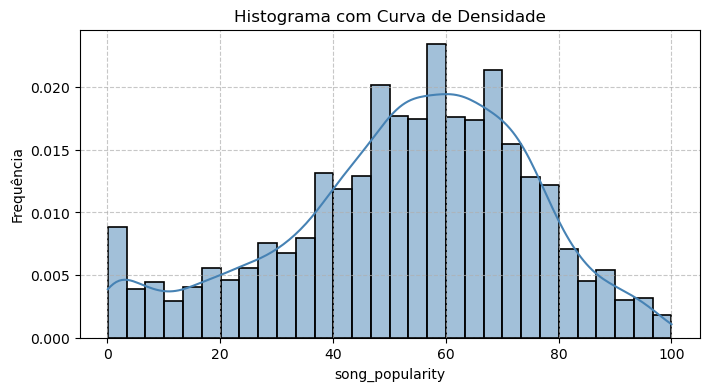

In [36]:
# Criando o histograma e a curva de densidade para a variável resposta
plt.figure(figsize=(8, 4))
sns.histplot(y_train_r, bins=30, kde=True, stat="density", color='steelblue', edgecolor='black', linewidth=1.2)
plt.xlabel('song_popularity')
plt.ylabel('Frequência')
plt.title('Histograma com Curva de Densidade')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

<Axes: ylabel='song_popularity'>

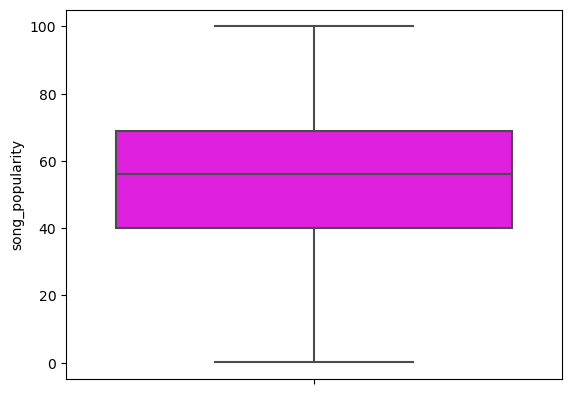

In [37]:
# Boxplot da variável resposta
sns.boxplot(y=y_train_r, color = 'magenta')

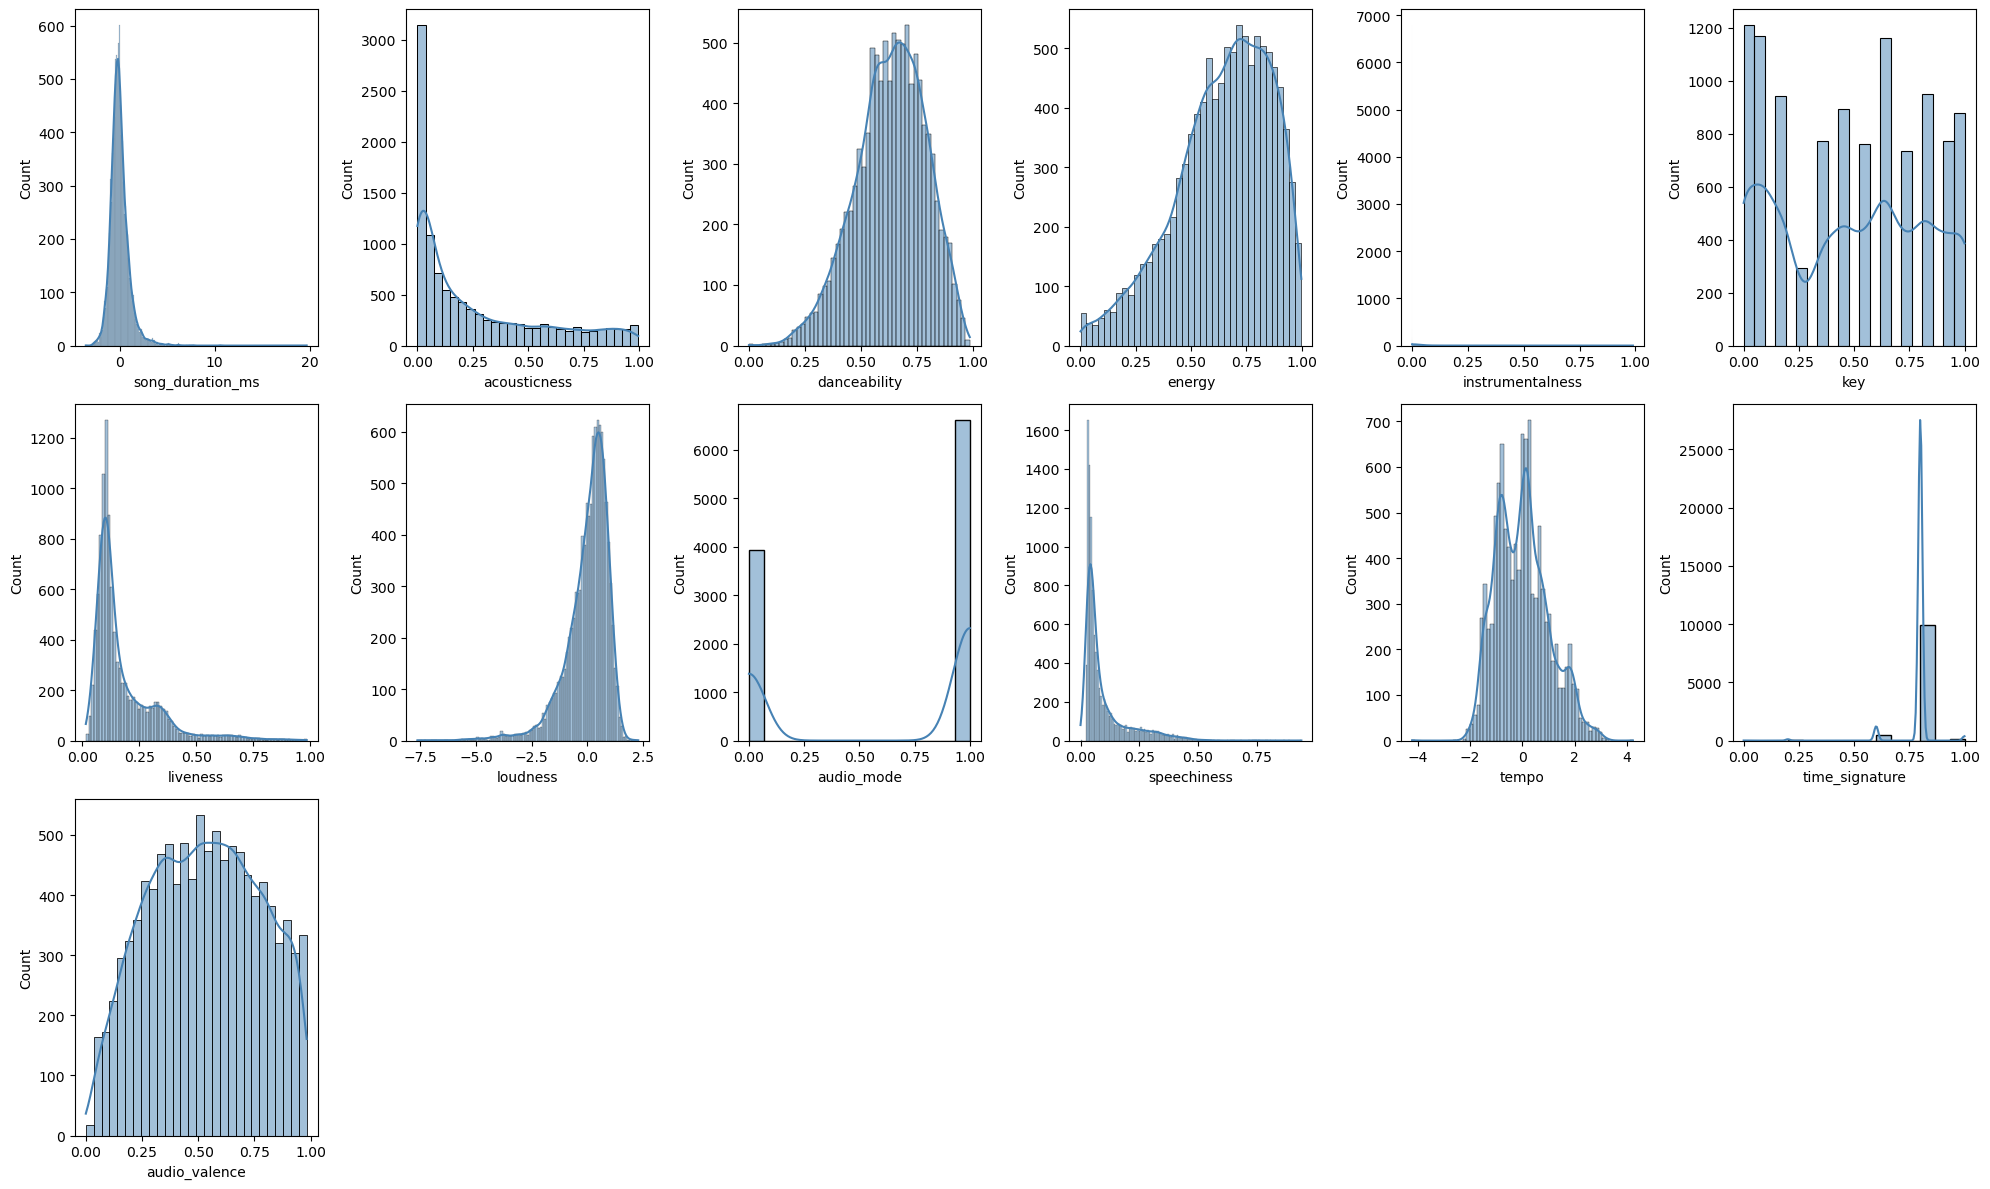

In [38]:
# Distribuição das variáveis independentes
features = X_train_r.columns
plt.figure(figsize = (20, 12))
for i, feature in enumerate(features):
    plt.subplot(3, int(len(features)/2), i+1)
    sns.histplot(x=X_train_r[feature], kde=True, color='steelblue', edgecolor='black')
    plt.xlabel(feature)
    plt.tight_layout()
plt.show()

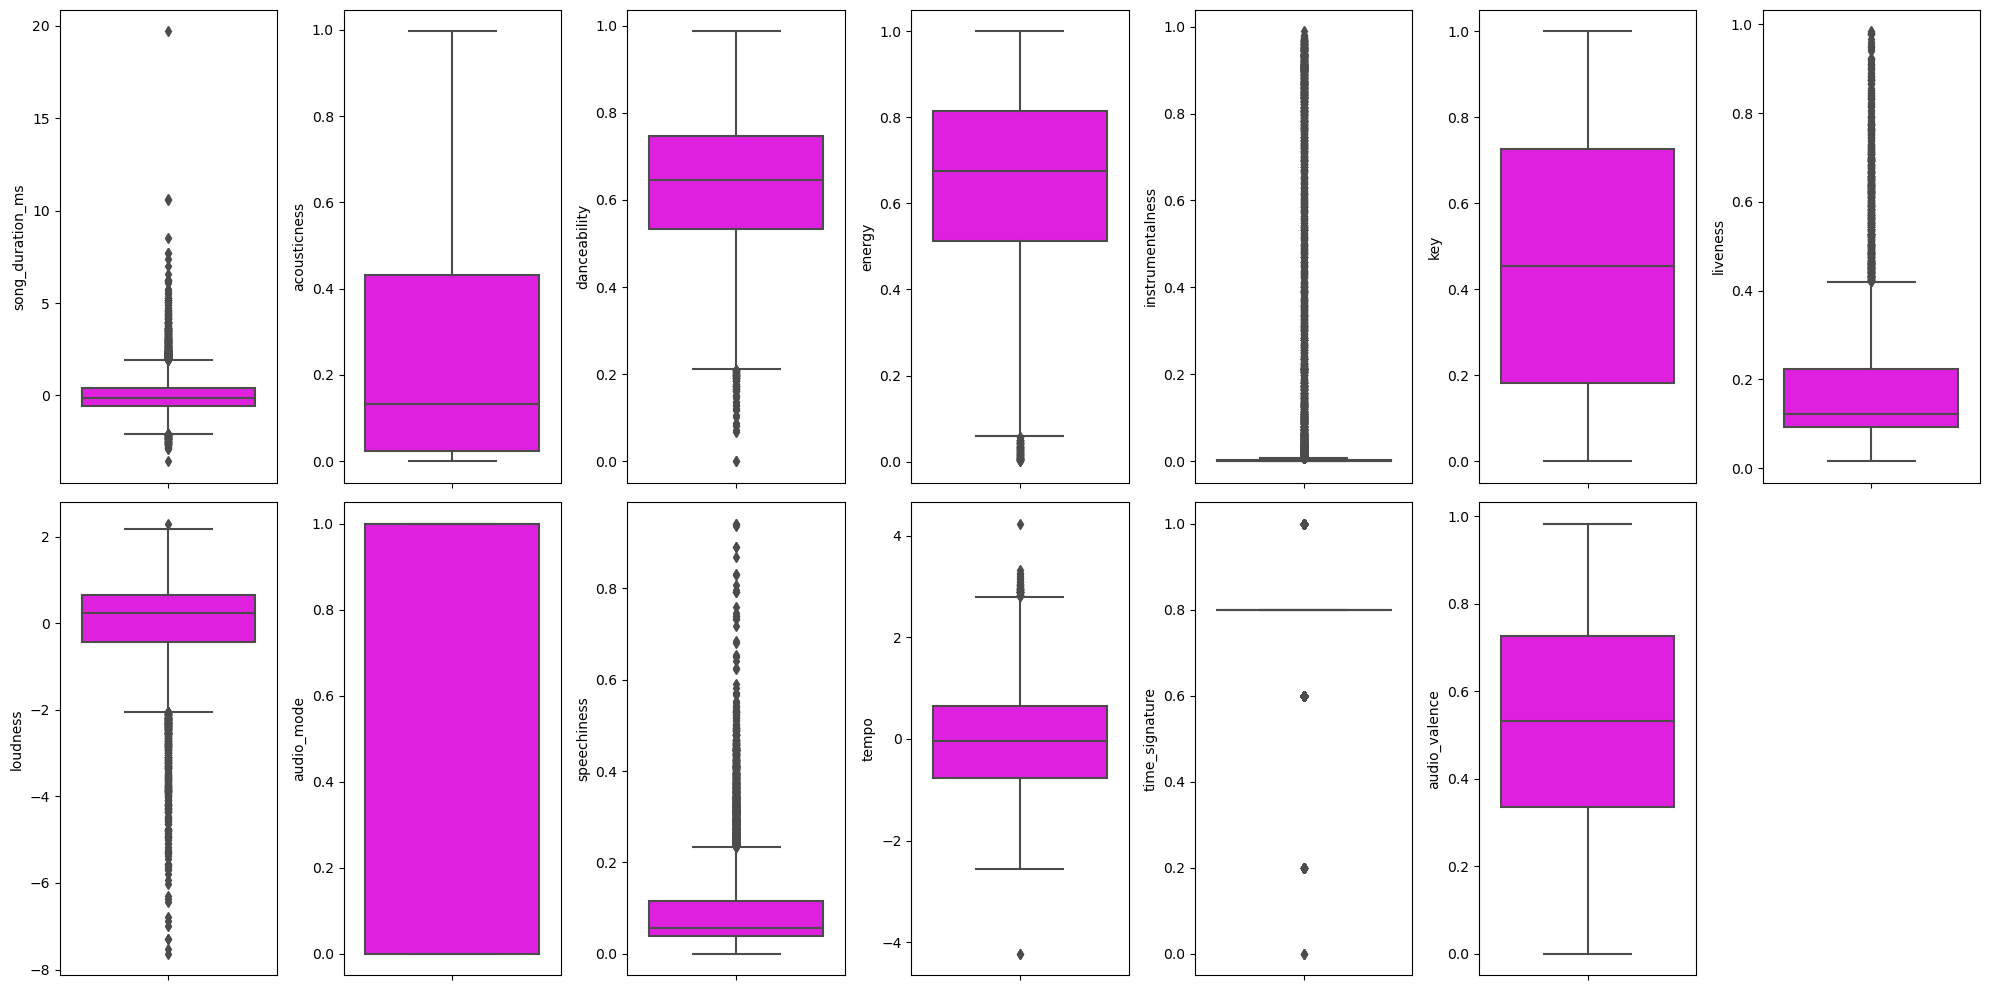

In [39]:
# Plotando boxplots para cada variável independente em um único gráfico
plt.figure(figsize=(20, 10))

features = X_train_r.columns
for i in range(0, len(features)):
    plt.subplot(2, int(len(features)/2) + 1, i+1)
    sns.boxplot(y=X_train_r[features[i]], color = 'magenta')
    plt.tight_layout()
plt.show()

### 2.6.2 Bivariate Analysis

<Axes: >

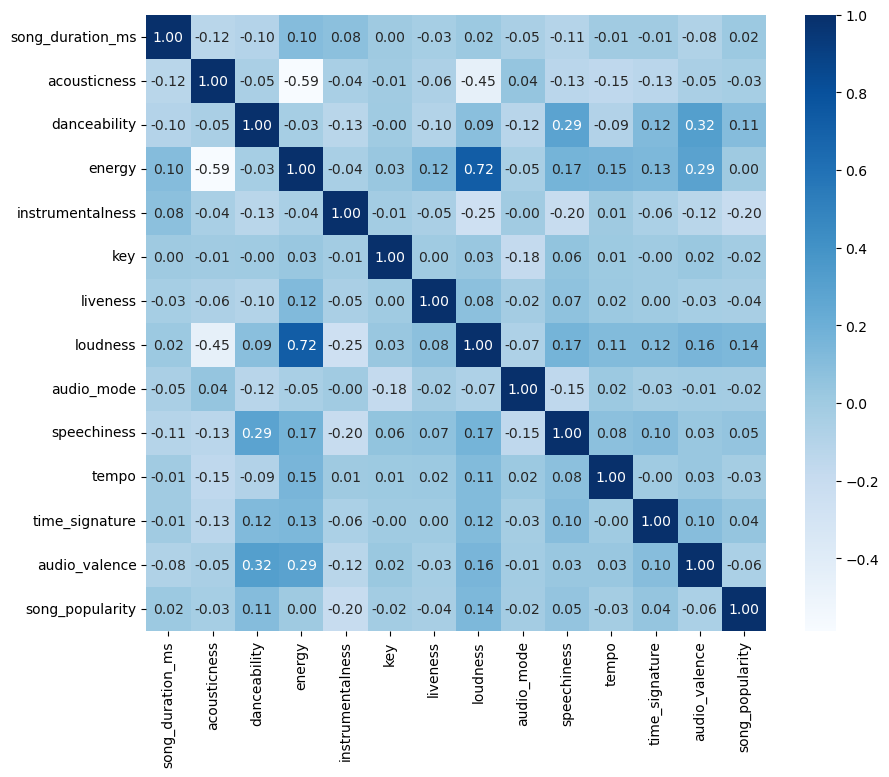

In [40]:
num_attributes_train = pd.concat([X_train_r, y_train_r], axis=1)

corr_df = num_attributes_train.corr(method='spearman')

plt.figure(figsize = (10, 8))
sns.heatmap(corr_df, cmap = 'Blues', annot = True, fmt = '.2f')

## 2.7 Transformação dos Dados

In [41]:
# Cria uma cópia dos DataFrames
X_train_r_scaled = X_train_r.copy()
X_val_r_scaled = X_val_r.copy()
X_test_r_scaled = X_test_r.copy()

In [42]:
# Selecionar as colunas para aplicar o MinMaxScaler
columns_min_max = ['key', 'audio_valence', 'acousticness', 'audio_mode']

# Criar o MinMaxScaler
scaler = MinMaxScaler()

# Ajustar o scaler usando o conjunto de treinamento
X_train_r_scaled[columns_min_max] = scaler.fit_transform(X_train_r[columns_min_max])

# Transformar o conjunto de validação usando o scaler ajustado
X_val_r_scaled[columns_min_max] = scaler.transform(X_val_r[columns_min_max])

# Transformar o conjunto de teste usando o scaler ajustado
X_test_r_scaled[columns_min_max] = scaler.transform(X_test_r[columns_min_max])

In [43]:
# Selecione as colunas restantes para aplicar o RobustScaler
columns_robust = X_train_r.columns.difference(columns_min_max)

# Crie o RobustScaler
robust_scaler = RobustScaler()

# Ajuste o scaler com os dados de treinamento e transforme
X_train_r_scaled[columns_robust] = robust_scaler.fit_transform(X_train_r[columns_robust])

# Transformar o conjunto de validação usando o scaler ajustado
X_val_r_scaled[columns_robust] = robust_scaler.transform(X_val_r[columns_robust])

# Transformar o conjunto de teste usando o scaler ajustado
X_test_r_scaled[columns_robust] = robust_scaler.transform(X_test_r[columns_robust])

## 2.8 O Ensaio de Machine Learning - Regressão

### 2.8.1 Linear Regression

In [44]:
# Define LinearRegression model
lr = lm.LinearRegression()

# Train model
lr.fit(X_train_r_scaled, y_train_r)

LinearRegression()

#### Performance sobre os dados de treino

In [45]:
lr_result_train = get_ml_performance(lr, X_train_r_scaled, y_train_r, classification=False)
lr_result_train

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Linear Regression,0.046,455.996,21.354,16.998,8.653


#### Performance sobre os dados de validação

In [46]:
lr_result_val = get_ml_performance(lr, X_val_r_scaled, y_val_r, classification=False)
lr_result_val

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Linear Regression,0.04,458.447,21.411,17.04,8.683


#### Performance sobre os dados de teste

In [47]:
lr_result_test = get_ml_performance(lr, X_test_r_scaled, y_test_r, classification=False)
lr_result_test

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Linear Regression,0.052,461.428,21.481,17.13,8.522


### 2.8.2 Decision Tree Regressor

In [48]:
# Defina a grade de hiperparâmetros a serem testados
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 32, 33, 34],
    'random_state': [42]
}

best_model, best_params, _ = grid_search(DecisionTreeRegressor(), param_grid, 
                                         X_train_r_scaled, y_train_r, X_val_r_scaled, y_val_r, classification=False)
print(best_params)

{'max_depth': 5, 'random_state': 42}


#### Performance sobre os dados de treino

In [49]:
dtr_result_train = get_ml_performance(best_model, X_train_r_scaled, y_train_r, classification=False)
dtr_result_train

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Decision Tree Regressor,0.104,428.127,20.691,16.46,8.184


#### Performance sobre os dados de validação

In [50]:
dtr_result_val = get_ml_performance(best_model, X_val_r_scaled, y_val_r, classification=False)
dtr_result_val

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Decision Tree Regressor,0.1,429.538,20.725,16.541,8.329


#### Performance sobre os dados de teste

In [51]:
dtr_result_test = get_ml_performance(best_model, X_test_r_scaled, y_test_r, classification=False)
dtr_result_test

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Decision Tree Regressor,0.09,443.296,21.055,16.83,7.886


### 2.8.3 Random Forest Regressor

In [52]:
# Defina a grade de hiperparâmetros a serem testados
# {'n_estimators': 250, 'max_depth': 25, 'random_state': 42}
param_grid = {
    'n_estimators': [ 175, 200, 225, 250],
    'max_depth': [10, 15, 20, 25, 30, None],
    'random_state': [42]
}

best_model, best_params, _ = grid_search(RandomForestRegressor(), param_grid, 
                                         X_train_r_scaled, y_train_r, 
                                         X_val_r_scaled, y_val_r, classification=False)
print(best_params)

{'n_estimators': 250, 'max_depth': 25, 'random_state': 42}


#### Performance sobre os dados de treino

In [53]:
rfr_result_train = get_ml_performance(best_model, X_train_r_scaled, y_train_r, classification=False)
rfr_result_train

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Random Forest Regressor,0.905,45.552,6.749,4.73,2.519


#### Performance sobre os dados de validação

In [54]:
rfr_result_val = get_ml_performance(best_model, X_val_r_scaled, y_val_r, classification=False)
rfr_result_val

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Random Forest Regressor,0.902,46.62,6.828,4.79,2.57


#### Performance sobre os dados de teste

In [55]:
rfr_result_test = get_ml_performance(best_model, X_test_r_scaled, y_test_r, classification=False)
rfr_result_test

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Random Forest Regressor,0.405,289.825,17.024,12.267,6.309


### 2.8.4 Polinomial Regression

In [56]:
pipeline = Pipeline([
    ('poly_features', PolynomialFeatures()),
    ('linear_regression', lm.LinearRegression())
])
pipeline.__class__.__name__ = 'Polinomial Regression'
param_grid = {
    'poly_features__degree': [2, 3, 4]
}

best_model, best_params, _ = grid_search(pipeline, param_grid, 
                                         X_train_r_scaled, y_train_r, 
                                         X_val_r_scaled, y_val_r, classification=False)
print(best_params)


{'poly_features__degree': 2}


#### Performance sobre os dados de treino

In [57]:
pr_result_train = get_ml_performance(best_model, X_train_r_scaled, y_train_r, classification=False)
pr_result_train

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Polinomial Regression,0.092,434.135,20.836,16.505,8.386


#### Performance sobre os dados de validação

In [58]:
pr_result_val = get_ml_performance(best_model, X_val_r_scaled, y_val_r, classification=False)
pr_result_val

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Polinomial Regression,0.081,439.046,20.953,16.62,8.508


#### Performance sobre os dados de teste

In [59]:
pr_result_test = get_ml_performance(best_model, X_test_r_scaled, y_test_r, classification=False)
pr_result_test

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Polinomial Regression,0.091,442.641,21.039,16.736,8.277


### 2.8.5 Linear Regression Lasso

In [60]:
# Defina a grade de hiperparâmetros a serem testados
param_grid = {
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [1, 6, 7, 8, 9, 10, 11, 15, 50, 100]
}

best_model, best_params, _ = grid_search(lm.Lasso(), param_grid, 
                                         X_train_r_scaled, y_train_r, X_val_r_scaled, y_val_r, classification=False)
print(best_params)

{'alpha': 1e-05, 'max_iter': 7}


#### Performance sobre os dados de treino

In [61]:
lrl_result_train = get_ml_performance(best_model, X_train_r_scaled, y_train_r, classification=False)
lrl_result_train

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Lasso,0.046,456.167,21.358,17.011,8.64


#### Performance sobre os dados de validação

In [62]:
lrl_result_val = get_ml_performance(best_model, X_val_r_scaled, y_val_r, classification=False)
lrl_result_val

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Lasso,0.041,457.794,21.396,17.035,8.667


#### Performance sobre os dados de teste

In [63]:
lrl_result_test = get_ml_performance(best_model, X_test_r_scaled, y_test_r, classification=False)
lrl_result_test

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Lasso,0.05,462.434,21.504,17.155,8.531


### 2.8.6 Linear Regression Ridge

In [64]:
# Defina a grade de hiperparâmetros a serem testados
param_grid = {
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [1, 6, 7, 8, 9, 10, 11, 15, 50, 100]
}

best_model, best_params, _ = grid_search(lm.Ridge(), param_grid, 
                                         X_train_r_scaled, y_train_r, X_val_r_scaled, y_val_r, classification=False)
print(best_params)

{'alpha': 1e-05, 'max_iter': 1}


#### Performance sobre os dados de treino

In [65]:
lrr_result_train = get_ml_performance(best_model, X_train_r_scaled, y_train_r, classification=False)
lrr_result_train

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Ridge,0.046,456.106,21.357,17.007,8.646


#### Performance sobre os dados de validação

In [66]:
lrr_result_val = get_ml_performance(best_model, X_val_r_scaled, y_val_r, classification=False)
lrr_result_val

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Ridge,0.041,457.823,21.397,17.034,8.673


#### Performance sobre os dados de teste

In [67]:
lrr_result_test = get_ml_performance(best_model, X_test_r_scaled, y_test_r, classification=False)
lrr_result_test

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Ridge,0.051,461.988,21.494,17.144,8.531


### 2.8.7 Linear Regression Elastic Net

In [68]:
# Defina a grade de hiperparâmetros a serem testados
param_grid = {
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [1, 6, 7, 8, 9, 10, 11, 15, 50, 100],
    'l1_ratio': [0, 0.2, 0.4, 0.6, 0.8, 1]
}

best_model, best_params, _ = grid_search(lm.ElasticNet(), param_grid, 
                                         X_train_r_scaled, y_train_r, X_val_r_scaled, y_val_r, classification=False)
print(best_params)

{'alpha': 1e-05, 'max_iter': 7, 'l1_ratio': 1}


#### Performance sobre os dados de treino

In [69]:
enr_result_train = get_ml_performance(best_model, X_train_r_scaled, y_train_r, classification=False)
enr_result_train

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Elastic Net,0.046,456.167,21.358,17.011,8.64


#### Performance sobre os dados de validação

In [70]:
enr_result_val = get_ml_performance(best_model, X_val_r_scaled, y_val_r, classification=False)
enr_result_val

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Elastic Net,0.041,457.794,21.396,17.035,8.667


#### Performance sobre os dados de teste

In [71]:
enr_result_test = get_ml_performance(best_model, X_test_r_scaled, y_test_r, classification=False)
enr_result_test

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Elastic Net,0.05,462.434,21.504,17.155,8.531


### 2.8.8 Polinomial Regression Lasso

In [72]:
pipeline = Pipeline([
    ('poly_features', PolynomialFeatures()),
    ('linear_regression_lasso', lm.Lasso())
])
pipeline.__class__.__name__ = 'Polinomial Regression Lasso'
param_grid = {
    'poly_features__degree': [2, 3, 4],
    'linear_regression_lasso__alpha': [0.00001, 0.0001, 0.001, 0.01],
    'linear_regression_lasso__max_iter': [10, 50, 100, 200, 500, 1000]
}

best_model, best_params, _ = grid_search(pipeline, param_grid, 
                                         X_train_r_scaled, y_train_r, 
                                         X_val_r_scaled, y_val_r, classification=False)
print(best_params)

{'poly_features__degree': 2, 'linear_regression_lasso__alpha': 0.01, 'linear_regression_lasso__max_iter': 200}


#### Performance sobre os dados de treinamento

In [73]:
prl_result_train = get_ml_performance(best_model, X_train_r_scaled, y_train_r, classification=False)
prl_result_train

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Polinomial Regression Lasso,0.09,435.191,20.861,16.534,8.404


#### Performance sobre os dados de validação

In [74]:
prl_result_val = get_ml_performance(best_model, X_val_r_scaled, y_val_r, classification=False)
prl_result_val

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Polinomial Regression Lasso,0.08,439.482,20.964,16.623,8.525


#### Performance sobre os dados de teste

In [75]:
prl_result_test = get_ml_performance(best_model, X_test_r_scaled, y_test_r, classification=False)
prl_result_test

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Polinomial Regression Lasso,0.091,442.488,21.035,16.736,8.308


### 2.8.9 Polinomial Regression Ridge

In [76]:
pipeline = Pipeline([
    ('poly_features', PolynomialFeatures()),
    ('linear_regression_ridge', lm.Ridge())
])
pipeline.__class__.__name__ = 'Polinomial Regression Ridge'
param_grid = {
    'poly_features__degree': [2, 3, 4],
    'linear_regression_ridge__alpha': [0.00001, 0.0001, 0.001, 0.01],
    'linear_regression_ridge__max_iter': [10, 50, 100, 200, 500, 1000]}

# Suprimir warnings ao redor da chamada do grid_search
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best_model, best_params, _ = grid_search(pipeline, param_grid, 
                                            X_train_r_scaled, y_train_r, 
                                            X_val_r_scaled, y_val_r, classification=False)
print(best_params)

{'poly_features__degree': 2, 'linear_regression_ridge__alpha': 0.01, 'linear_regression_ridge__max_iter': 10}


#### Performance sobre os dados de treinamento

In [77]:
prr_result_train = get_ml_performance(best_model, X_train_r_scaled, y_train_r, classification=False)
prr_result_train

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Polinomial Regression Ridge,0.092,434.135,20.836,16.505,8.386


#### Performance sobre os dados de validação

In [78]:
prr_result_val = get_ml_performance(best_model, X_val_r_scaled, y_val_r, classification=False)
prr_result_val

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Polinomial Regression Ridge,0.081,439.046,20.953,16.62,8.508


#### Performance sobre os dados de teste

In [79]:
prr_result_test = get_ml_performance(best_model, X_test_r_scaled, y_test_r, classification=False)
prr_result_test

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Polinomial Regression Ridge,0.091,442.639,21.039,16.736,8.277


### 2.8.10 Polinomial Regression Elastic Net

In [80]:
pipeline = Pipeline([
    ('poly_features', PolynomialFeatures()),
    ('linear_regression_elastic_net', lm.ElasticNet())
])
pipeline.__class__.__name__ = 'Polinomial Regression Elastic Net'
param_grid = {
    'poly_features__degree': [2, 3, 4],
    'linear_regression_elastic_net__alpha': [0.00001, 0.0001, 0.001, 0.01],
    'linear_regression_elastic_net__max_iter': [10, 50, 100, 200, 500, 1000],
    'linear_regression_elastic_net__l1_ratio': [0, 0.2, 0.4, 0.6, 0.8, 1]}

# Suprimir warnings ao redor da chamada do grid_search
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best_model, best_params, _ = grid_search(pipeline, param_grid, 
                                            X_train_r_scaled, y_train_r, 
                                            X_val_r_scaled, y_val_r, classification=False)
print(best_params)

{'poly_features__degree': 2, 'linear_regression_elastic_net__alpha': 0.01, 'linear_regression_elastic_net__max_iter': 200, 'linear_regression_elastic_net__l1_ratio': 1}


#### Performance sobre os dados de treinamento

In [81]:
pren_result_train = get_ml_performance(best_model, X_train_r_scaled, y_train_r, classification=False)
pren_result_train

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Polinomial Regression Elastic Net,0.09,435.191,20.861,16.534,8.404


#### Performance sobre os dados de validação

In [82]:
pren_result_val = get_ml_performance(best_model, X_val_r_scaled, y_val_r, classification=False)
pren_result_val

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Polinomial Regression Elastic Net,0.08,439.482,20.964,16.623,8.525


#### Performance sobre os dados de teste

In [83]:
pren_result_test = get_ml_performance(best_model, X_test_r_scaled, y_test_r, classification=False)
pren_result_test

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Polinomial Regression Elastic Net,0.091,442.488,21.035,16.736,8.308


## 2.9 Resultado Final

### Dados de Treinamento

In [84]:
training_results_regression = pd.concat([lr_result_train, dtr_result_train, rfr_result_train, pr_result_train, 
                                         lrl_result_train, lrr_result_train, enr_result_train,
                                         prl_result_train, prr_result_train, pren_result_train])
training_results_regression = training_results_regression.reset_index(drop=True)
training_results_regression

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Linear Regression,0.046,455.996,21.354,16.998,8.653
1,Decision Tree Regressor,0.104,428.127,20.691,16.460,8.184
2,Random Forest Regressor,0.905,45.552,6.749,4.730,2.519
3,Polinomial Regression,0.092,434.135,20.836,16.505,8.386
4,Lasso,0.046,456.167,21.358,17.011,8.640
5,Ridge,0.046,456.106,21.357,17.007,8.646
6,Elastic Net,0.046,456.167,21.358,17.011,8.640
7,Polinomial Regression Lasso,0.090,435.191,20.861,16.534,8.404
8,Polinomial Regression Ridge,0.092,434.135,20.836,16.505,8.386
9,Polinomial Regression Elastic Net,0.090,435.191,20.861,16.534,8.404


### Dados de Validação

In [85]:
training_results_validation = pd.concat([lr_result_val, dtr_result_val, rfr_result_val, pr_result_val, 
                                         lrl_result_val, lrr_result_val, enr_result_val,
                                         prl_result_val, prr_result_val, pren_result_val])
training_results_validation = training_results_validation.reset_index(drop=True)
training_results_validation

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Linear Regression,0.040,458.447,21.411,17.040,8.683
1,Decision Tree Regressor,0.100,429.538,20.725,16.541,8.329
2,Random Forest Regressor,0.902,46.620,6.828,4.790,2.570
3,Polinomial Regression,0.081,439.046,20.953,16.620,8.508
4,Lasso,0.041,457.794,21.396,17.035,8.667
5,Ridge,0.041,457.823,21.397,17.034,8.673
6,Elastic Net,0.041,457.794,21.396,17.035,8.667
7,Polinomial Regression Lasso,0.080,439.482,20.964,16.623,8.525
8,Polinomial Regression Ridge,0.081,439.046,20.953,16.620,8.508
9,Polinomial Regression Elastic Net,0.080,439.482,20.964,16.623,8.525


### Dados de Teste

In [86]:
training_results_test = pd.concat([lr_result_test, dtr_result_test, rfr_result_test, pr_result_test, 
                                         lrl_result_test, lrr_result_test, enr_result_test,
                                         prl_result_test, prr_result_test, pren_result_test])
training_results_test = training_results_test.reset_index(drop=True)
training_results_test

,Algoritmo,R2,MSE,RMSE,MAE,MAPE
0,Linear Regression,0.052,461.428,21.481,17.130,8.522
1,Decision Tree Regressor,0.090,443.296,21.055,16.830,7.886
2,Random Forest Regressor,0.405,289.825,17.024,12.267,6.309
3,Polinomial Regression,0.091,442.641,21.039,16.736,8.277
4,Lasso,0.050,462.434,21.504,17.155,8.531
5,Ridge,0.051,461.988,21.494,17.144,8.531
6,Elastic Net,0.050,462.434,21.504,17.155,8.531
7,Polinomial Regression Lasso,0.091,442.488,21.035,16.736,8.308
8,Polinomial Regression Ridge,0.091,442.639,21.039,16.736,8.277
9,Polinomial Regression Elastic Net,0.091,442.488,21.035,16.736,8.308


# 3.0 Clusterização

## 3.1 Load Data

In [87]:
X = pd.read_csv("./datasets/clustering/X_dataset.csv")

X.head()

,alcohol,malic_acid,ash,ash_alcanity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280,proline
0,1.518613,0.191700,0.232053,-1.169593,1.913905,0.627586,0.573840,-0.659563,1.224884,0.251717,0.455285,0.970696,0.561341
1,0.246290,0.205534,-0.827996,-2.490847,0.018145,0.575862,0.510549,-0.820719,-0.544721,-0.293321,0.463415,0.780220,0.550642
2,0.196879,0.320158,1.109334,-0.268738,0.088358,0.627586,0.611814,-0.498407,2.135968,0.269020,0.447154,0.695971,0.646933
3,1.691550,0.239130,0.487926,-0.809251,0.930918,0.989655,0.664557,-0.981875,1.032155,1.186068,0.308943,0.798535,0.857347
4,0.295700,0.365613,1.840403,0.451946,1.281985,0.627586,0.495781,0.226796,0.401404,-0.319276,0.455285,0.608059,0.325963


## 3.2 Data Dimension

In [88]:
print('Number of rows in X_:', X.shape[0])
print('Number of cols in X:', X.shape[1])

Number of rows in X_: 178
Number of cols in X: 13


## 3.3 Data Types

In [89]:
# Verifica os tipos de mtodas as colunas de X
X.dtypes

alcohol                 float64
malic_acid              float64
ash                     float64
ash_alcanity            float64
magnesium               float64
total_phenols           float64
flavanoids              float64
nonflavanoid_phenols    float64
proanthocyanins         float64
color_intensity         float64
hue                     float64
od280                   float64
proline                 float64
dtype: object

## 3.4 Check NA

In [90]:
X.isna().sum()

alcohol                 0
malic_acid              0
ash                     0
ash_alcanity            0
magnesium               0
total_phenols           0
flavanoids              0
nonflavanoid_phenols    0
proanthocyanins         0
color_intensity         0
hue                     0
od280                   0
proline                 0
dtype: int64

## 3.5 Estatística Descritiva

In [91]:
get_descriptive_statistics(X)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,alcohol,-2.434235,2.259772,4.694007,-8.382808e-16,0.061000,1.002821,-0.051482,-0.852500
1,malic_acid,0.000000,1.000000,1.000000,3.154839e-01,0.222332,0.220780,1.039651,0.299207
2,ash,-3.679162,3.156325,6.835488,-8.170742e-16,-0.023821,1.002821,-0.176699,1.143978
3,ash_alcanity,-2.671018,3.154511,5.825529,-3.991813e-17,0.001518,1.002821,0.213047,0.487942
4,magnesium,-2.088255,4.371372,6.459627,-3.991813e-17,-0.122282,1.002821,1.098191,2.104991
5,total_phenols,0.000000,1.000000,1.000000,4.534870e-01,0.474138,0.215811,0.086639,-0.835627
6,flavanoids,0.000000,1.000000,1.000000,3.563860e-01,0.378692,0.210730,0.025344,-0.880382
7,nonflavanoid_phenols,-1.868234,2.402403,4.270637,3.592632e-16,-0.176095,1.002821,0.450151,-0.637191
8,proanthocyanins,-2.069034,3.485073,5.554107,-1.197544e-16,-0.062898,1.002821,0.517137,0.554649
9,color_intensity,-1.634288,3.435432,5.069720,3.991813e-17,-0.159225,1.002821,0.868585,0.381522


## 3.6 Transformação dos Dados

In [92]:
scaler = MinMaxScaler()  

# Ajusta o scaler aos dados de treinamento e transforma
X_scaled = scaler.fit_transform(X)

In [93]:
get_descriptive_statistics(pd.DataFrame(X_scaled, columns=X.columns))

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,alcohol,0.0,1.0,1.0,0.518584,0.531579,0.213639,-0.051482,-0.852500
1,malic_acid,0.0,1.0,1.0,0.315484,0.222332,0.220780,1.039651,0.299207
2,ash,0.0,1.0,1.0,0.538244,0.534759,0.146708,-0.176699,1.143978
3,ash_alcanity,0.0,1.0,1.0,0.458502,0.458763,0.172142,0.213047,0.487942
4,magnesium,0.0,1.0,1.0,0.323278,0.304348,0.155244,1.098191,2.104991
5,total_phenols,0.0,1.0,1.0,0.453487,0.474138,0.215811,0.086639,-0.835627
6,flavanoids,0.0,1.0,1.0,0.356386,0.378692,0.210730,0.025344,-0.880382
7,nonflavanoid_phenols,0.0,1.0,1.0,0.437460,0.396226,0.234818,0.450151,-0.637191
8,proanthocyanins,0.0,1.0,1.0,0.372523,0.361199,0.180555,0.517137,0.554649
9,color_intensity,0.0,1.0,1.0,0.322363,0.290956,0.197806,0.868585,0.381522


## 3.7 O Ensaio de Machine Learning - Regressão

### 3.7.1 K-Means

In [117]:
n_cluster = np.arange(2,31)
ss_avglist =[]

for k in n_cluster:
    #definition
    kmeans = ct.KMeans( n_clusters = k,n_init=10)
    
    # fit
    labels = kmeans.fit_predict( X_scaled )
    
    # performance
    ss_avg = round(mt.silhouette_score( X_scaled, labels ),3)
    ss_avglist.append(ss_avg)

#### Performance Para o melhor valor de K

In [118]:
max_ss = max(ss_avglist)
index_max = ss_avglist.index(max_ss)

print (' K:{} , Silhouette Score: {}'.format(n_cluster[index_max], max_ss))

 K:3 , Silhouette Score: 0.301


Text(0, 0.5, 'Silhouette Score')

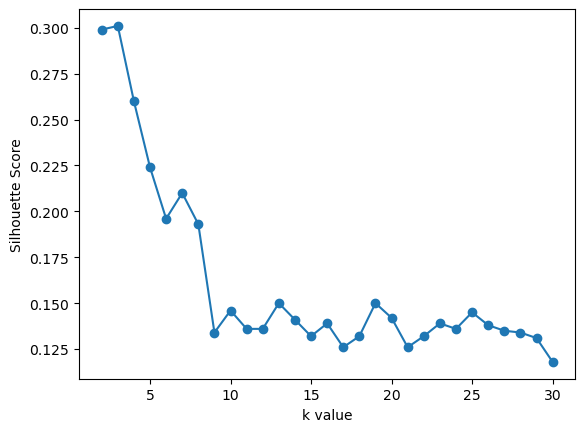

In [119]:
# Elbow Method
plt.plot( n_cluster, ss_avglist, marker='o')
plt.xlabel('k value')
plt.ylabel('Silhouette Score')

In [120]:
result_kmeans = pd.DataFrame({'Algoritmo': 'K-Means',
                             'Número de clusters': n_cluster[index_max],
                             'Average Silhouette Score': max_ss}, index=[0])
result_kmeans

,Algoritmo,Número de clusters,Average Silhouette Score
0,K-Means,3,0.301


### 3.7.2 Affinity Propagation

In [139]:
p = np.arange( -1, -40, -1 )
ss_avglist_ap = []
for i in range( len( p ) ):

    #definition
    model = ct.AffinityPropagation( preference=p[i] )
    
    # fit
    labels = model.fit_predict( X_scaled)
    
    if len( model.cluster_centers_indices_ ) == 1:
        break

    # performance
    ss_avg = round(mt.silhouette_score( X_scaled, labels ),3)
    ss_avglist_ap.append(ss_avg)

#### Performance Para o melhor valor de preference

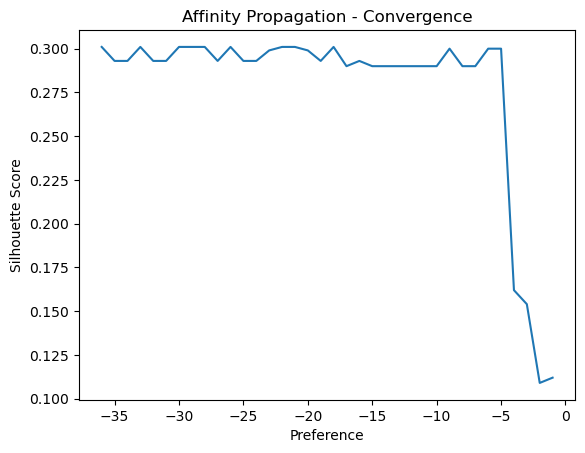

In [140]:
# Plot
plt.plot( np.arange( -1, -len(ss_avglist_ap)-1, -1 ), ss_avglist_ap );
plt.title( 'Affinity Propagation - Convergence' );
plt.xlabel( 'Preference' );
plt.ylabel( 'Silhouette Score' );
plt.show();

In [141]:
ss_avglist.index( max( ss_avglist_ap ))

1

In [142]:
best_preference = p[ ss_avglist_ap.index( max( ss_avglist_ap ) ) ]
print(f"A melhor Silhouette Score media de valor igual a {max( ss_avglist_ap )} foi obtida com preferencia igual a {best_preference}")

A melhor Silhouette Score media de valor igual a 0.301 foi obtida com preferencia igual a -18


In [144]:
af_model = ct.AffinityPropagation( preference=best_preference )
af_model.fit(X_scaled)

print('Para o melhor modelo foram encontrados {} clusters.'.format( len( af_model.cluster_centers_indices_ )))

Para o melhor modelo foram encontrados 2 clusters.


In [145]:
result_af = pd.DataFrame({'Algoritmo': 'Affinity Propagation',
                             'Número de clusters': len( af_model.cluster_centers_indices_ ),
                             'Average Silhouette Score': max( ss_avglist_ap )}, index=[0])

result_af

,Algoritmo,Número de clusters,Average Silhouette Score
0,Affinity Propagation,2,0.301


## 3.8 Resultado Final

In [146]:
results_clustering = pd.concat([result_kmeans, result_af])
results_clustering = results_clustering.reset_index(drop=True)
results_clustering

,Algoritmo,Número de clusters,Average Silhouette Score
0,K-Means,3,0.301
1,Affinity Propagation,2,0.301
